In [159]:
import numpy as np 
import numba as nb
from matplotlib import pyplot as plt

## Canvas + Camera

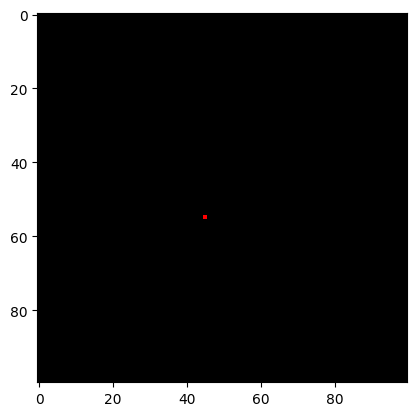

In [286]:
camera = {
    
    "position": (0,0,0),
    "orientation": [[1,0,0],[0,1,0],[0,0,1]],
    "d": 1,
    "w": 1,
    "h": 1,

    "canvas" : {
        "resolution":(100,100),
        "pixels": None,
    }
}

def initialize_camera(camera):
    resolution = camera["canvas"]["resolution"]
    camera["canvas"]["pixels"] = np.zeros((resolution[0], resolution[1], 3))
    return camera


@nb.njit()
def center2pixel(resolution, x, y):
    return (int(resolution[0]//2) - y, int(resolution[1]//2) + x)

@nb.njit()
def write_pixel(pixels, resolution, x, y, color):
    x,y = center2pixel(resolution, x,y)
    pixels[x][y] = color

    return color

def show(canvas):
    plt.imshow(canvas["pixels"])
    plt.show()

@nb.njit()
def canvas2world(x,y, resolution, w, h, d):
    return (x*w/resolution[0], y*h/resolution[1], d)


camera = initialize_camera(camera)

write_pixel(camera['canvas']['pixels'], camera['canvas']['resolution'], -5, -5, np.array([1,0,0]))

show(camera["canvas"])


## Lights

In [161]:
lights = [
    {"type":"PointLight", "position": np.array([0, 0, 0.5]), "intensity": 1},
]

@nb.njit()
def get_L_point_light(P, light_position):
    return light_position - P

@nb.njit()
def get_L(P, light_position, light_type):
    if light_type == "PointLight":
        return get_L_point_light(P, light_position) 
    else:
        raise Exception("Light type not implemented")


light = lights[0]
get_L(np.array([0,0,1]), light["position"], light["type"])

array([ 0. ,  0. , -0.5])

## Materials

In [162]:
class PhongMaterial():
    def __init__(self, color, ambient=0.4, specular=0.9, reflective=0.2):
        self.color = np.array(color)
        self.ambient = ambient
        self.specular = specular
        self.reflective = reflective

## Rays

In [163]:
ray = {"origin": np.array([0, 0, 0]), 
       "direction": np.array([1, 0, 0]),
       "tmin": 0,
       "tmax":np.inf}

@nb.njit()
def p(ray_origin, ray_direction, t):
    return ray_origin + ray_direction * t

## Primitives

In [164]:
@nb.njit()
def intersect_sphere(sphere_position, sphere_radius, ray_origin, ray_direction):
    ray_dot = ray_direction[0]**2+ray_direction[1]**2+ray_direction[2]**2
    a = ray_dot


    delta = ray_origin-sphere_position
    delta_ray_dot = delta[0]*ray_direction[0]+delta[1]*ray_direction[1]+delta[2]*ray_direction[2]
    b = 2*delta_ray_dot
    
    delta_dot = delta[0]**2+delta[1]**2+delta[2]**2
    c = delta_dot - sphere_radius**2

    discriminant = b**2 - 4*a*c

    if discriminant < 0:
        return [np.inf]
    else:
        t1 = (-b - np.sqrt(discriminant))/(2*a)
        t2 = (-b + np.sqrt(discriminant))/(2*a)
        return [t1,t2]


@nb.njit()
def normal_sphere(point, sphere_position, sphere_radius):
    return (point-sphere_position)/sphere_radius


intersect_sphere(np.array([0,0,0]), 1, np.array([0,0,-3]), np.array([0,0,1]))

normal_sphere(np.array([0,0,0]), np.array([0,0,0]), 1)


array([0., 0., 0.])

In [233]:
@nb.njit()
def closest_intersection(ray_origin, ray_direction, ray_tmin, ray_tmax, spheres):
    closest_t = np.inf
    closest_sphere_position = np.array([0,0,0], dtype=np.float64)
    closest_sphere_radius = -1
    
    for sphere in spheres:
        sphere_position = sphere[:3]
        sphere_radius = sphere[3]
        ts = intersect_sphere(sphere_position, sphere_radius, ray_origin, ray_direction)

        for t in ts:
            if (ray_tmin < t < ray_tmax) and t < closest_t:
                closest_t = t
                closest_sphere_position = sphere_position
                closest_sphere_radius = sphere_radius

    if closest_sphere_radius == -1:
        return [-9999., -9999., -9999., -9999., -9999.]
    
    else:
        return [closest_t, 
                closest_sphere_position[0],
                closest_sphere_position[1],
                closest_sphere_position[2],
                closest_sphere_radius]


closest_intersection(np.array([0,0,0]), 
                     np.array([0,0,1]), 
                     0, 
                     np.inf, np.array([[0,0,1.5, 1.]]))


[0.5, 0.0, 0.0, 1.5, 1.0]

In [195]:
@nb.njit()
def t(a,b,c,d,e):
    if a>0:
        return [0,0,0,0,0]
    else:
        return [a,b,c,d,e]


t(1,2,3,4,5)
    

[0, 0, 0, 0, 0]

In [166]:
@nb.njit()
def hemisphere2world(theta,phi):
    x = np.sin(theta)*np.cos(phi)
    y = np.cos(theta)
    z = np.sin(theta)*np.sin(phi)
    return np.array([x,y,z])


hemisphere2world(1, 1)

@nb.njit()
def sample_uniform_hemisphere(r1,r2):
    sin_theta = np.sqrt(1-r1**2)
    phi = 2*np.pi*r2

    x = sin_theta*np.cos(phi)
    y = r1 # cos(theta)
    z = sin_theta*np.sin(phi)

    return np.array([x,y,z])

sample_uniform_hemisphere(1, 1)

@nb.njit()
def create_local_coordinate_system(N):
    N_norm = np.sqrt(N[0]**2 + N[1]**2 + N[2]**2)
    if (N[0]>N[1]):
        Nt = np.array([N[2], 0, -N[0]]) / N_norm
    else:
        Nt = np.array([0, -N[2], N[1]]) / N_norm
    Nb = np.cross(N,Nt)

    return Nb, Nt, N


create_local_coordinate_system(np.array([1, 1, 1]))




@nb.njit()
def local2world(P_local, N_world):
    Nt, Nb, _ = create_local_coordinate_system(N_world)

    A = np.array([[Nb[0], N_world[0], Nt[0]],
                  [Nb[1], N_world[1], Nt[1]],
                  [Nb[2], N_world[2], Nt[2]]])

    C = np.zeros(3)
    for i in nb.prange(3):
        for j in nb.prange(3):
            C[i] += A[i,j] * P_local[j]

    return C


def local2world_np(P_local, N_world):
    Nt, Nb, _ = create_local_coordinate_system(N_world)

    A = np.array([[Nb[0], N_world[0], Nt[0]],
                  [Nb[1], N_world[1], Nt[1]],
                  [Nb[2], N_world[2], Nt[2]]])

    return np.matmul(A,P_local)

res1 = local2world_np(np.array([3,1,2]), np.array([4,5,1]))
res2 = local2world(np.array([3,1,2]), np.array([4,5,1]))


for i in range(3):
    assert res1[i] == res2[i]


In [167]:
from PIL import Image

skybox_image_cubemap = Image.open("skyboxes/miramar.jpeg")
skybox_image_cubemap = np.array(skybox_image_cubemap)


def split_cubemap(skybox_image, height, total_width):
    face_width = total_width // 4

    images = [
            skybox_image[face_width:2*face_width, 2*face_width:3*face_width], # POSITIVE X
            skybox_image[face_width:2*face_width, 0:face_width], # NEGATIVE X
            skybox_image[0:face_width, face_width:2*face_width], # POSITIVE Y
            skybox_image[2*face_width:3*face_width, face_width:2*face_width], # NEGATIVE Y
            skybox_image[face_width:2*face_width, face_width:2*face_width], # POSITIVE Z
            skybox_image[face_width:2*face_width, 3*face_width:4*face_width], # NEGATIVE Z
            ]
    
    return images

skybox_images = split_cubemap(skybox_image_cubemap, *skybox_image_cubemap.shape[:2])

skybox_images = np.array(skybox_images)

@nb.njit()
def sphere2pixel(P, image_height, image_width):
    x,y,z = P
    abs_x, abs_y, abs_z = np.abs(P)

    x_positive = x>0
    y_positive = y>0
    z_positive = z>0

    # POSITIVE X
    if x_positive and abs_x >= abs_y and abs_x >= abs_z:
        max_axis = abs_x
        uc = -z
        vc = y
        index = 0

    # NEGATIVE X
    if not x_positive and abs_x >= abs_y and abs_x >= abs_z:
        max_axis = abs_x
        uc = z
        vc = y
        index = 1
    
    # POSITIVE Y
    if y_positive and abs_y >= abs_x and abs_y >= abs_z:
        max_axis = abs_y
        uc = x
        vc = -z
        index = 2
    
    # NEGATIVE Y
    if not y_positive and abs_y >= abs_x and abs_y >= abs_z:
        max_axis = abs_y
        uc = x
        vc = z
        index = 3

    # POSITIVE Z
    if z_positive and abs_z >= abs_x and abs_z >= abs_y:
        max_axis = abs_z
        uc = x
        vc = y
        index = 4
    
    # NEGATIVE Z
    if not z_positive and abs_z >= abs_x and abs_z >= abs_y:
        max_axis = abs_z
        uc = -x
        vc = y
        index = 5

    # convert from (-1,1) to (0,1)
    u = 0.5 * (uc / max_axis + 1)
    v = 0.5 * (vc / max_axis + 1)

    pixel = [v,u]

    pixel = (int(image_height-pixel[0]*image_height), 
             int(pixel[1]*image_width)-1)

    return pixel[0], pixel[1], index


sphere2pixel(np.array([1,0,0]), skybox_images[0].shape[0], skybox_images[0].shape[1])


@nb.njit()
def get_color(P, skybox_images):
    height, width, _ = skybox_images[0].shape
    x, y, index = sphere2pixel(P, height, width)
    return skybox_images[index][x,y]




get_color(np.array([1,0,0]), skybox_images)

array([134, 164, 175], dtype=uint8)

## Scene

In [169]:
@nb.njit()
def is_in_shadow(P, light_position, spheres):
    L = get_L_point_light(P, light_position)
    
    res = closest_intersection(P, L, 0.001, np.inf, spheres)

    if res is None:
        return False
    else:
        return True


spheres = np.array([[0,0,1.5, 1.]])

is_in_shadow(np.array([0,0,0]), lights[0]["position"], spheres)

True

In [308]:
@nb.njit()
def illuminate(light_position, light_intensity, 
              P, N, V, 
              material_color, 
              material_ambient, 
              material_specular, 
              material_reflective, 
              shadow):
              
    L = get_L_point_light(P, light_position)
    N_dot_L = N[0]*L[0] + N[1]*L[1] + N[2]*L[2]

    I = 0

    if shadow:
        return I
    
    if N_dot_L > 0:
        L_norm = np.sqrt(L[0]**2 + L[1]**2 + L[2]**2)
        N_norm = np.sqrt(N[0]**2 + N[1]**2 + N[2]**2)
        I += light_intensity * N_dot_L/(L_norm*N_norm)

    if material_specular > 0:
        R = 2*N_dot_L - L
        R_dot_V = R[0]*V[0] + R[1]*V[1] + R[2]*V[2]
        if R_dot_V > 0:
            R_norm = np.sqrt(R[0]**2 + R[1]**2 + R[2]**2)
            V_norm = np.sqrt(V[0]**2 + V[1]**2 + V[2]**2)
            I+= light_intensity * (R_dot_V/(R_norm*V_norm))**material_specular

    return I


illuminate(lights[0]["position"], 
           lights[0]["intensity"],
           np.array([0,0,0]), 
           np.array([0,0,1]), 
           np.array([0,0,0]), np.array([255,255,255]), 0.4, 0.8, 500, True)

@nb.njit()
def compute_lighting(P, N, V, lights, spheres, material_color, material_ambient, material_specular, material_reflective):
    I = material_ambient
    for light in lights:
        light_position = light[:3]
        light_intensity = light[3]

        shadow = is_in_shadow(P, light_position, spheres)
        I += illuminate(light_position, light_intensity, P, N, V, material_color, material_ambient, material_specular, material_reflective, shadow)

    return material_color*I


compute_lighting(np.array([0,0,0]), np.array([0,0,1]), np.array([0,0,0]), np.array([[0,0,0.5,1]]), spheres, np.array([255,0,0]), 0.4, 0.4, 99)

@nb.njit()
def optional_np_array(x):
    if x is None:
        return np.array([])
    else:
        return np.array(x)

@nb.njit()
def trace_ray(ray_origin, ray_direction, ray_tmin, ray_tmax, spheres, lights, depth=1, max_depth=5):

    res = closest_intersection(ray_origin, ray_direction, ray_tmin, ray_tmax, spheres)

    if res[0] == -9999.:
        return get_color(ray_direction, skybox_images=skybox_images).astype(np.float64)
        return np.array([0.,0.,0.])

    else: 
        closest_t = res[0]
        closest_sphere_position = np.array(res[1:4])
        closest_sphere_radius = res[4]


        intensity = 0

        P = p(ray_origin, ray_direction, closest_t)

        N = normal_sphere(P,
                        closest_sphere_position, 
                        closest_sphere_radius)
        V = -ray_direction

        local_color = compute_lighting(P, N, V, lights, spheres,
                                    np.array([255,0,0]), 0.2, 0, 0.4) 


        # indirecet illumination 
        N_world = np.array([0,1,0])
        r1 = np.random.rand()
        r2 = np.random.rand()
        local_coordinate = sample_uniform_hemisphere(r1,r2)
        ray_direction = local2world(local_coordinate, N_world)

        pdf = 1/(2*np.pi)

        indirect_color = r1*trace_ray(P, ray_direction, 0.001, np.inf, spheres, lights, depth+1, max_depth)/pdf

        albedo = 1
        return albedo*(local_color + indirect_color)/np.pi

trace_ray(np.array([0,0,0.3]), np.array([0,0,1]), 0.001, np.inf, spheres, np.array([[0,0,0.5,1]]), 1, 5)
    

array([35.29653942, 12.50276454, 13.64738383])

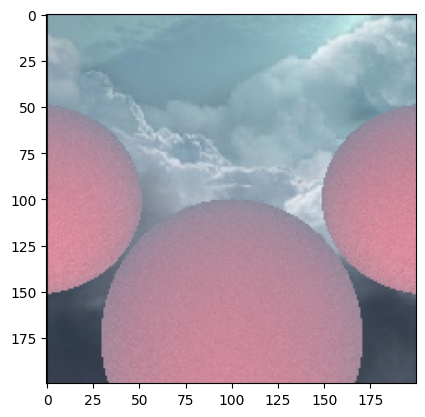

In [310]:
@nb.njit(parallel=True)
def render():

    camera = {
        "position": np.array([0.,0.,0.],dtype=np.float64),
        # "orientation": [[1,0,0],[0,1,0],[0,0,1]],
        "d": 1,
        "w": 1,
        "h": 1,

        "canvas" : {
            "resolution":np.array((200,200),dtype=np.float64),
            "pixels": np.zeros((200,200,3), dtype=np.float64),
        }
    }


    spheres = np.array([[0.,-1.,3.,1.], [-2.,0.,4.,1.], [2.,0.,4.,1.]])
    lights = np.array([[0.,0.,0.,0.7]])



    xmin = -int(camera['canvas']['resolution'][0]//2)+1
    xmax = int(camera['canvas']['resolution'][0]//2)
    ymin = -int(camera['canvas']['resolution'][1]//2)+1
    ymax = int(camera['canvas']['resolution'][1]//2)
    for x in nb.prange(xmin, xmax):
        for y in nb.prange(ymin, ymax):

            color = np.array([0,0,0], dtype=np.float64)
            n_samples = 1000

            for _ in nb.prange(n_samples):
                noise = 0.5
                x_ = x + (np.random.rand()-0.5)*noise
                y_ = y + (np.random.rand()-0.5)*noise

                # (x,y, resolution, w, h, d)
                D = canvas2world(x,y,camera['canvas']['resolution'], camera['w'], camera['h'], camera['d'])
                ray_origin = camera['position']
                ray_direction = np.array(D)

                # ray_origin, ray_direction, ray_tmin, ray_tmax, spheres, lights
                color += trace_ray(ray_origin, ray_direction, 0.001, np.inf, spheres, lights)

            color /= n_samples
            

            # pixels, resolution, x, y, color
            # print(x,y)
            write_pixel(camera['canvas']['pixels'], camera['canvas']['resolution'], int(x), int(y), color)

    return camera['canvas']['pixels']


pixels = render()

plt.imshow(pixels.astype(int))